# GNN Tracking Sandbox

A generalisable notebook to:
* Create and load tracking data, 
* Configure edge construction (if using non-End2End classification), 
* Visualise graph data,
* Configure training parameters,
* Construct GNN architecture,
* Run automated tests,
* Track test output for architecture comparison,
* Export data, architecture and tests for production runs

## Dependencies

In [62]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
import logging

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [63]:
# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive, fixed
from IPython.display import display

from functools import partial

In [64]:
# Local imports
from sandbox_utils import *
from interaction_utils import *
%matplotlib inline

## Create or Load Graph Dataset

### Generate data

Use the event generator to generate 2- or 3-D dataset. Run the next cell to choose dataset parameters.

### Load TrackML data

Or load pre-generated data from a file location



Run the cell of the relevant side to either generate or load data. Hit "Run interact" once parameters are chosen. 

N.B. Generator may take longer for a very **small** angle cut (as many graphs won't have adequate edges and require regeneration) and very **large** angle cut (as then there is a large set of possible edges to generate).

In [60]:
# Generate data
config_path = "/global/u2/d/danieltm/ExaTrkX/eta-tracker/notebooks/datasetConfig.yaml"
generator = interactive(gen_edge_class_dataset, {"manual":True, "auto_display":False}, **sliders("dataset", config_path) )
display(generator)

interactive(children=(FloatSlider(value=10.0, continuous_update=False, description='num_layers', max=15.0, min…

Run the next cell to store the generated data to a dataset list. Change the split as required.

In [96]:
dataset = generator.result
dataset_split = interactive(split_dataset, dataset=fixed(dataset), **sliders( "split", config_path) )
dataset_split

interactive(children=(FloatSlider(value=60.0, continuous_update=False, description='train_percent', max=90.0, …

In [6]:
train_dataset, test_dataset = dataset_split.result

## Visualise Dataset

We can visualise some basic information about the training dataset here.

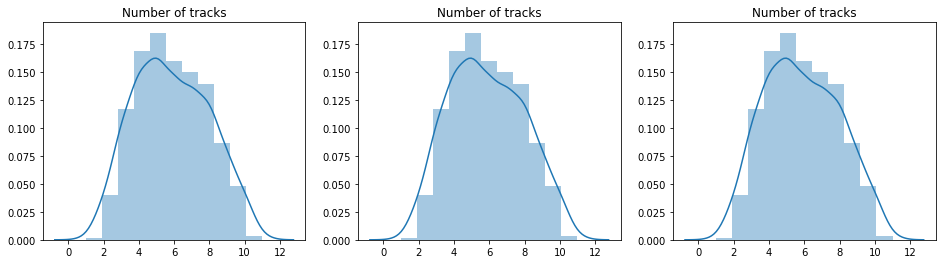

In [67]:
visualise_training_dataset(train_dataset)

## GNN Architecture

We can build a new architecture from scratch, or load a YAML architecture, which is then built into a GNN model. Use the builder to:
* Define the overall structure (number of convolutions, number of poolings, type of classification - node, edge or graph)
* Choose the convolutions and poolings from a custom set in the /architecture folder, or from the predefined methods in Pytorch Geometric
* Structure the order of these convolutions and poolings, and the number of recursions
* Choose the MLP structure for each convolution (number of channels, number of layers)
* Choose the MLP structure for input and output layers (number of layers)

The input and output MLP channels are defined automatically by the type of classification. 

### Generate Architecture

Use the dropboxes below to choose the number of {node, edge, graph} {convolutions, poolings}

In [8]:
# Generate data - NEED TO ABSTRACT MUCH OF THIS AWAY!
config_path = "/global/u2/d/danieltm/ExaTrkX/eta-tracker/notebooks/architectureConfig.yaml"
GNN_multiple_generator = interactive(return_same, **dropdowns_range("multiples", config_path) )
GNN_layer_generator = [interactive(return_same) for i in range(len(GNN_multiple_generator.children))]
display(GNN_multiple_generator)
# button = widgets.Button(description="Click Me!")
# build_layer_list_partial = partial(build_layer_list, GNN_layer_generator)
# button.on_click(build_layer_list_partial)
# display(button)
layer_list = {}
dropdown_watcher(GNN_multiple_generator.children[0], GNN_layer_generator[0], "node", "convolutions", layer_list)
dropdown_watcher(GNN_multiple_generator.children[1], GNN_layer_generator[1], "node", "poolings", layer_list)
dropdown_watcher(GNN_multiple_generator.children[2], GNN_layer_generator[2], "edge", "convolutions", layer_list)
dropdown_watcher(GNN_multiple_generator.children[3], GNN_layer_generator[3], "edge", "poolings", layer_list)
dropdown_watcher(GNN_multiple_generator.children[4], GNN_layer_generator[4], "graph", "convolutions", layer_list)
dropdown_watcher(GNN_multiple_generator.children[5], GNN_layer_generator[5], "graph", "poolings", layer_list)

interactive(children=(Dropdown(description='multiples of unique node convolutions', options=(0, 1, 2, 3, 4, 5,…

Then use the following dropboxes to choose the methods used for each of the above layers

In [9]:
[display(i) for i in GNN_layer_generator]

interactive(children=(Output(),), _dom_classes=('widget-interact',))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

interactive(children=(Output(),), _dom_classes=('widget-interact',))

[None, None, None, None, None, None, None]

### Save Architecture

In [148]:
with open("sketches/steve_model.yaml","r") as f:
    modelConfig = yaml.safe_load(f)

In [149]:
modelConfig['pipeline']

['input',
 'shortcut',
 {4: ['edgenet', 'nodenet', 'shortcut']},
 'edgenet',
 'output']

In [133]:
pipeline = ["input", "shortcut", {"loop1": ["edge1", "node1", "shortcut"]}, "edge1"]
architecture = {"input": {"type": InputNetwork, "inputs": "x", "outputs": "x"}, "edge1": {"type": EdgeNetwork, "param": 4}, "node1": {"type": NodeNetwork, "param": 4}, "shortcut": {"type": Shortcut}}
loops = {"loop1": 4}        

In [135]:
class Network():
    def __init__(self, pipeline, architecture, loops, input_dim=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=nn.Tanh, layer_norm=True):
        super(Network, self).__init__()
        self.pipeline = pipeline
        self.loops = loops
        self.architecture = architecture
        self.operations = {k: v['type'](input_dim, hidden_dim, hidden_activation, layer_norm) for (k, v) in architecture.items()}

    def forward(self, inputs, iterations=1, pipeline = None):
        values = {}
        values["inputs"] = inputs.x
        if pipeline is None: pipeline = self.pipeline
        for i in range(iterations):
            for j in pipeline: 
                if type(j) is dict:
                    values = forward(input, iterations = self.loops[list(j.keys())[0]], pipeline=list(j.values())[0])
                else: 
                    values[self.architecture[j]["outputs"]] = self.operations[j](values[self.architecture[j]["inputs"]])        
        return values

In [136]:
Network(pipeline, architecture, loops)

In [126]:
for j in pipeline:
    if type(j) is dict: 
        print(j.keys())
    else: 
        print("Not")

Not
Not
dict_keys(['loop1'])
Not


In [65]:
from models.agnn import *

In [123]:
# Externals
import torch
import torch.nn as nn
from torch_scatter import scatter_add

# Locals
from models.utils import make_mlp

class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh,
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp((input_dim+hidden_dim)*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, x, edge_index):
        # Select the features of the associated nodes
        start, end = edge_index
        x1, x2 = x[start], x[end]
        edge_inputs = torch.cat([x[start], x[end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, hidden_dim, hidden_activation=nn.Tanh,
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp((input_dim+hidden_dim)*3, [hidden_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=hidden_activation,
                                layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        start, end = edge_index
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(e[:, None] * x[start], end, dim=0, dim_size=x.shape[0])
        mo = scatter_add(e[:, None] * x[end], start, dim=0, dim_size=x.shape[0])
        node_inputs = torch.cat([mi, mo, x], dim=1)
        return self.network(node_inputs)
    
class InputNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, hidden_dim, hidden_activation=nn.Tanh,
                 layer_norm=True):
        super(InputNetwork, self).__init__()
        self.network = make_mlp(input_dim, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)

    def forward(self, x, e, edge_index):
        return self.network(x)
    
class Shortcut(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, hidden_dim, hidden_activation=nn.Tanh,
                 layer_norm=True):
        super(Shortcut, self).__init__()

    def forward(self, x, inputs):
        return torch.cat([x, inputs], dim=1)

## GNN Training

## GNN Testing

## Export for Production